## 1. Data Upload

In [285]:
import os
import pandas as pd
import numpy as np
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from scipy.optimize import minimize

In [286]:
# Load the Iris dataset
iris = datasets.load_iris()
iris_features = iris.data
iris_labels = iris.target
iris_target_names = iris.target_names

In [287]:
# Create a DataFrame from the features and labels
iris_df = pd.DataFrame(iris_features, columns=iris.feature_names)
iris_df['label'] = iris_labels
iris_df['label_name'] = iris_df['label'].apply(lambda x: iris_target_names[x])

# Save the DataFrame to a CSV file
csv_file_path = f'.\projects_temp-data\my_iris_dataset.csv'
iris_df.to_csv(csv_file_path, index=False)

csv_file_path

'.\\projects_temp-data\\my_iris_dataset.csv'

## 2. Multi-dimensional scaling

In [288]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(iris_features)

# Apply MDS to reduce the dimensions to 2
mds = MDS(n_components=2, normalized_stress='auto')
X_mds = mds.fit_transform(X_scaled)

# Apply t-SNE to reduce the dimensions to 2
# tsne = TSNE(n_components=2, random_state=42, n_iter=500)
# X_tsne = tsne.fit_transform(X_scaled)

# Convert the reduced data back to a pandas DataFrame
iris_reduced = pd.DataFrame(X_mds, columns=["x1", "x2"])
iris_reduced['labels'] = iris_labels


In [289]:
iris_reduced

,x1,x2,labels
0,1.355343,1.893822,0
1,0.198765,2.192878,0
2,0.633519,2.317671,0
3,0.369314,2.366958,0
4,1.555367,1.947923,0
...,...,...,...
145,-0.350297,-1.916422,2
146,-1.489033,-1.076534,2
147,-0.355014,-1.517677,2
148,0.709236,-1.766086,2


## 3. Visual analytics

In [290]:
def interpolate_coordinates(x_1, x_n, n):
    """
    This function calculates the values of the interpolate_coordinates
    of a line based on its first and last coordinates.
    :param x_1:
    :param x_n:
    :param n:
    :return:
    """
    # Ensure n is greater than 1 to avoid division by zero
    if n <= 1:
        raise ValueError("n must be greater than 1 to calculate intermediate points.")

    # List to hold all the coordinates including the first and the last
    inter_coordinates = []

    # Calculate each intermediate coordinate
    for i in range(0, n):
        x_i = x_1 + ((x_n - x_1) * i) / (n - 1)
        inter_coordinates.append(x_i)

    return inter_coordinates


In [317]:
x_1_first = -2
x_2_first = 2

x_1_last = 4
x_2_last = -2

# The number of intermediate points
num_inter_points = iris_features.shape[1]

x_1_inter_coordinates = interpolate_coordinates(x_1_first, x_1_last, num_inter_points)
x_2_inter_coordinates = interpolate_coordinates(x_2_first, x_2_last, num_inter_points)
# print(x_1_inter_coordinates)
# print(x_2_inter_coordinates)

# Create a DataFrame from the coordinates
coordinates_df = pd.DataFrame({'x1': x_1_inter_coordinates, 'x2': x_2_inter_coordinates})
coordinates_df


,x1,x2
0,-2.0,2.000000
1,0.0,0.666667
2,2.0,-0.666667
3,4.0,-2.000000


In [318]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# %config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn-v0_8-pastel')
FIGURE_FORMAT = 'svg'
PATH_FIGURES = '.\projects_temp-figs'

In [319]:
def plot_hyper_line(save_path):

    NUM_TICKS = 1

    # Define the figure name and path
    figure_name = f'my_hyper_line'
    my_save_path = os.path.join(save_path, figure_name + f'.{FIGURE_FORMAT}')
    
    # Define colors for each species
    colors = ['red', 'green', 'blue']
    
    # Plotting
    plt.figure(figsize=(9,5), dpi=300)
    
    # Set tick frequency using MultipleLocator
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(NUM_TICKS))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(NUM_TICKS))
    
    # Plot each species
    for item, species in enumerate(iris_target_names):
        subset = iris_reduced[iris_reduced['labels'] == item]
        plt.scatter(subset['x1'], subset['x2'], color=colors[item], label=species)
    
        # Annotate each point with its class label
        for _, row in subset.iterrows():
            plt.annotate(str(item), (row['x1'], row['x2']), textcoords="offset points", xytext=(6,-6), ha='center', fontsize=8)
    
    # Draw the separating line
    line_x1 = coordinates_df['x1'].tolist()
    line_x2 = coordinates_df['x2'].tolist()
    plt.plot(line_x1, line_x2, 'k-')  # 'k-' for black line
    
    # Highlight points on the separating line
    # If coordinates_df contains these points, plot them with a distinct style
    plt.scatter(line_x1, line_x2, color='k', marker='^', label='dividing line')

    plt.xticks(fontsize=12, fontweight='bold', color='#333333')
    plt.yticks(fontsize=12, fontweight='bold', color='#333333')
    plt.xlabel('X1', fontsize=12, fontweight='bold', color='#333333')
    plt.ylabel('X2', fontsize=12, fontweight='bold', color='#333333')
    plt.title('Visual analytics by human-in-the-loop', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.savefig(my_save_path, format=FIGURE_FORMAT, bbox_inches='tight')
    
    plt.show()

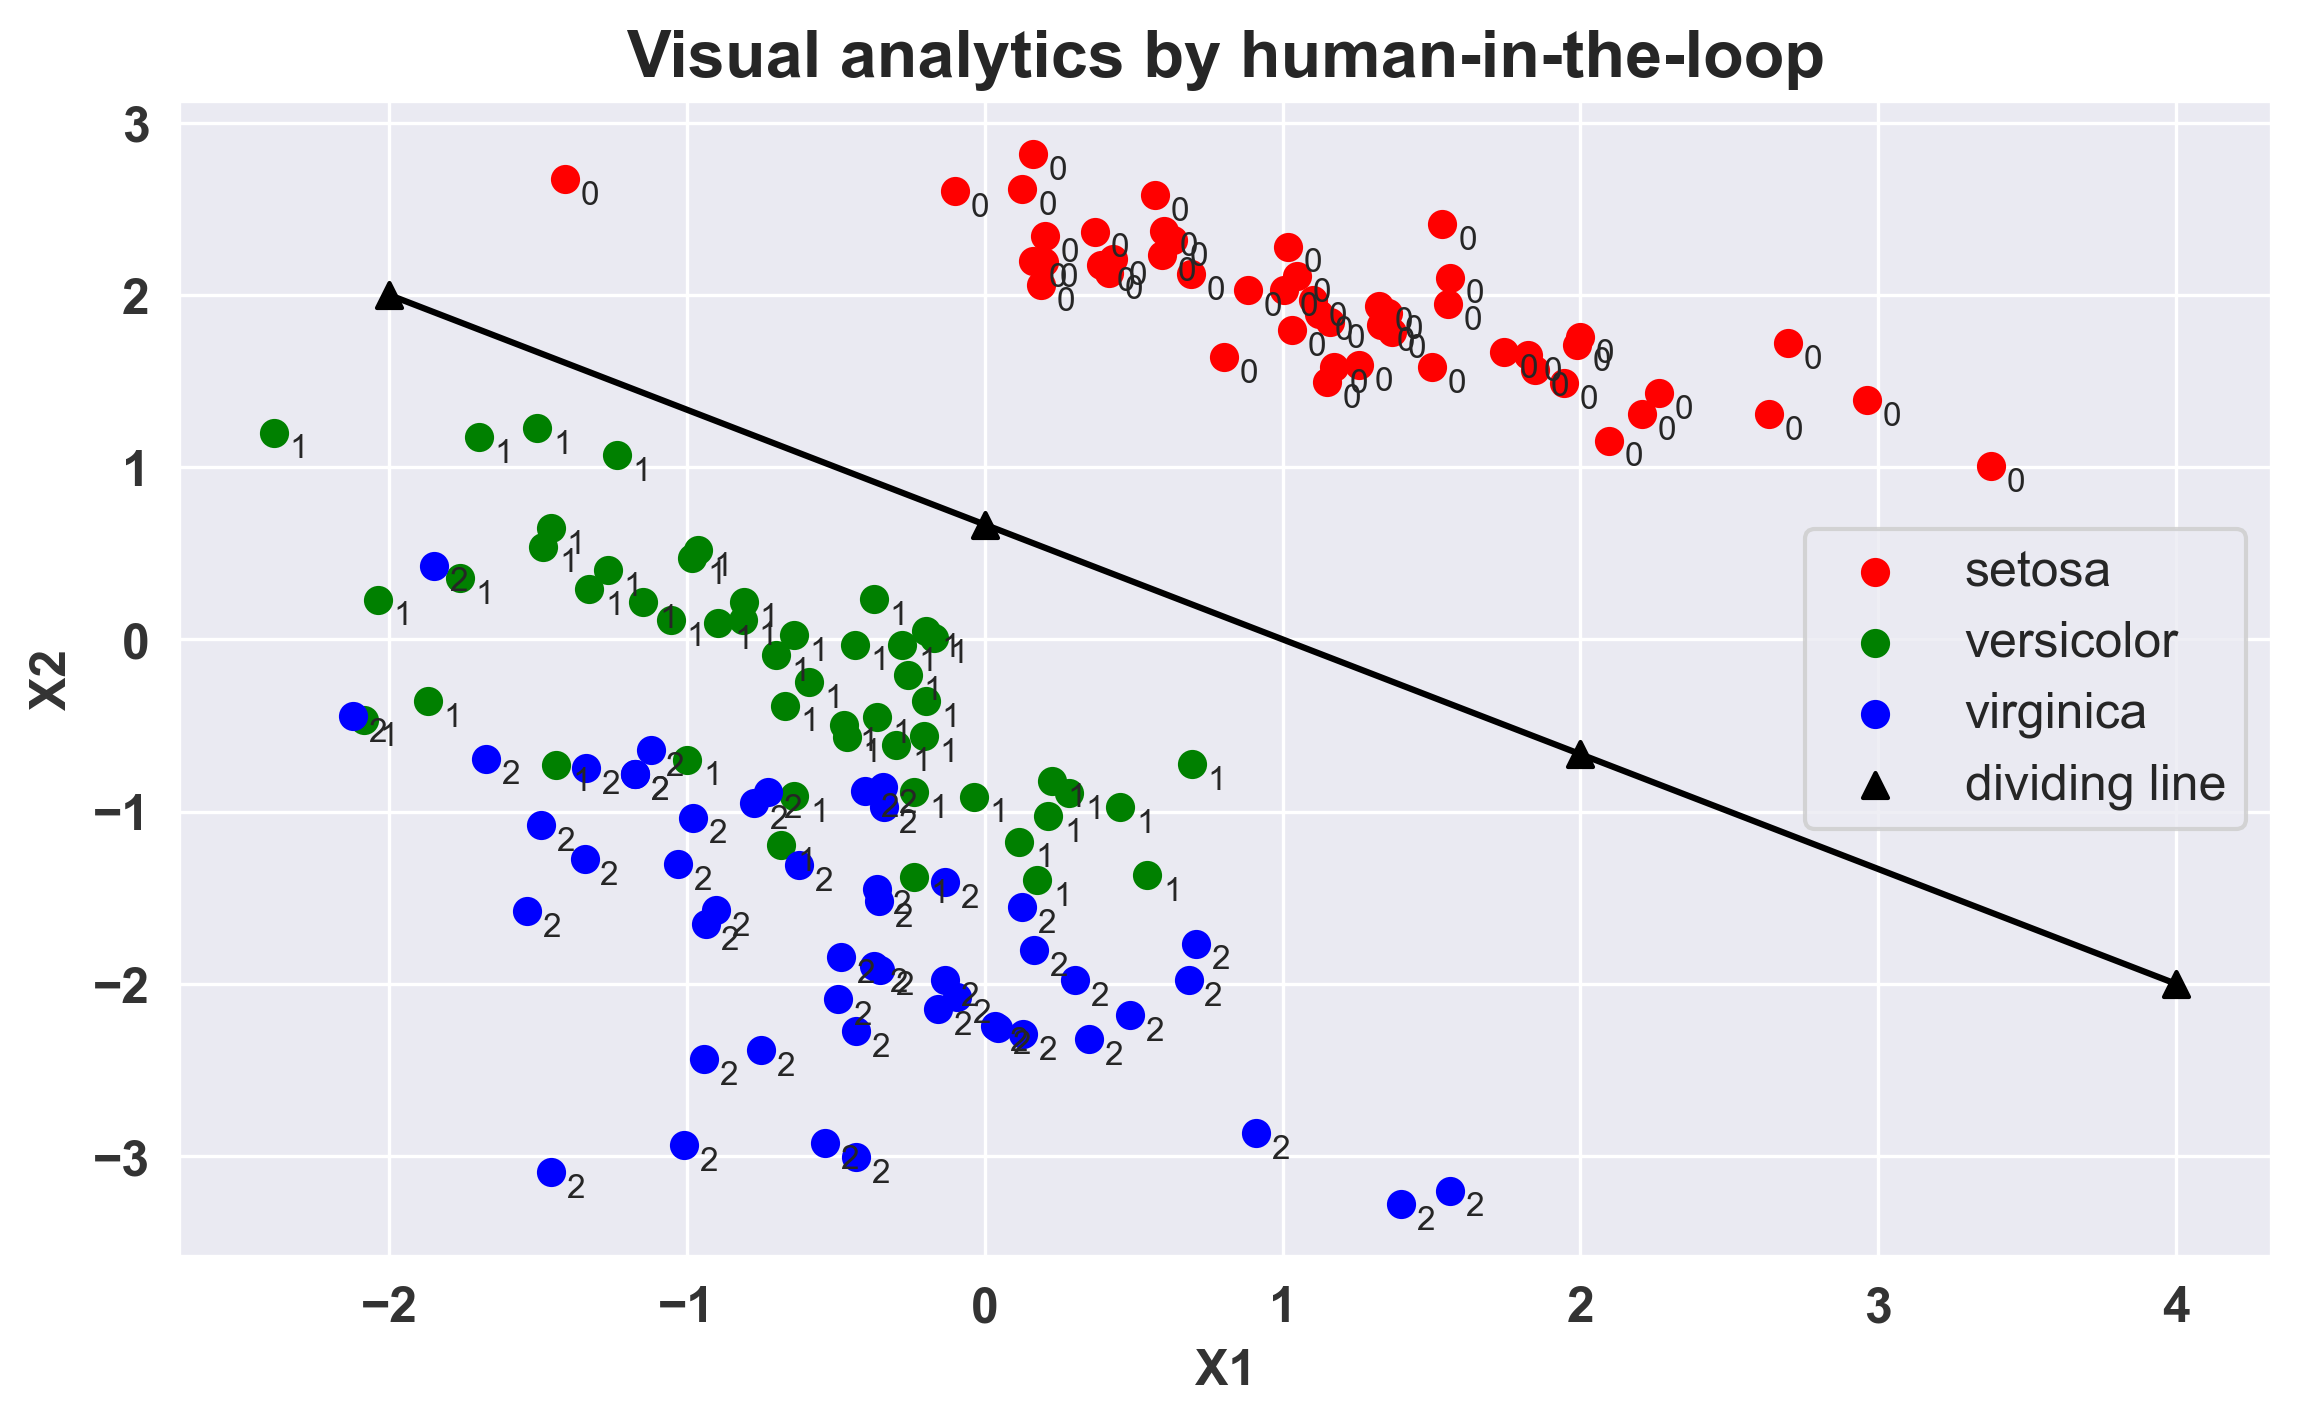

In [320]:
plot_hyper_line(save_path=PATH_FIGURES)

## 4. Calculate Transition Matrix

### 4.1. Singular Value Decomposition (SVD)

In [321]:
# Receive values from the matrix A DataFrame 
formal_model_reduced_values = iris_reduced.drop('labels', axis=1).values

# Calculate SVD
U, s, Vt = np.linalg.svd(formal_model_reduced_values)

# Construct the full diagonal matrix
S = np.zeros(formal_model_reduced_values.shape)
for i in range(min(formal_model_reduced_values.shape)):
    S[i, i] = s[i]

# print("U:\n", U)
# print("\nS:\n", S)
# print("\nVt:\n", Vt)


In [322]:
formal_model_reduced_values

array([[ 1.35534336,  1.8938219 ],
       [ 0.19876489,  2.19287805],
       [ 0.63351898,  2.31767138],
       [ 0.36931379,  2.36695824],
       [ 1.55536718,  1.94792319],
       [ 2.20753678,  1.30635982],
       [ 1.01708334,  2.28000096],
       [ 1.1009007 ,  1.96789881],
       [-0.10045559,  2.60330836],
       [ 0.43133185,  2.20533819],
       [ 1.84746933,  1.56529419],
       [ 1.04808764,  2.10720903],
       [ 0.20291366,  2.34164665],
       [ 0.16110374,  2.81952482],
       [ 2.63398902,  1.3077382 ],
       [ 3.37660888,  1.00533082],
       [ 2.26430251,  1.42936043],
       [ 1.32934332,  1.82443715],
       [ 2.09435425,  1.15361538],
       [ 1.98839771,  1.70773948],
       [ 1.17194474,  1.58013722],
       [ 1.74296438,  1.66543981],
       [ 1.53674116,  2.40951782],
       [ 0.80173575,  1.63947052],
       [ 1.00361718,  2.02892398],
       [ 0.18743249,  2.05721473],
       [ 1.0317939 ,  1.79434308],
       [ 1.36755139,  1.78249985],
       [ 1.16049564,

### 4.2. Create the reconstructed matrix of SVD

In [323]:
# Recompute the original matrix using U, S, and Vt
reconstructed_matrix = U.dot(S.dot(Vt))

# Convert the reconstructed matrix to a pandas DataFrame, if desired
reconstructed_df = pd.DataFrame(reconstructed_matrix)


In [324]:
reconstructed_df

,0,1
0,1.355343,1.893822
1,0.198765,2.192878
2,0.633519,2.317671
3,0.369314,2.366958
4,1.555367,1.947923
...,...,...
145,-0.350297,-1.916422
146,-1.489033,-1.076534
147,-0.355014,-1.517677
148,0.709236,-1.766086


In [325]:
iris_reduced

,x1,x2,labels
0,1.355343,1.893822,0
1,0.198765,2.192878,0
2,0.633519,2.317671,0
3,0.369314,2.366958,0
4,1.555367,1.947923,0
...,...,...,...
145,-0.350297,-1.916422,2
146,-1.489033,-1.076534,2
147,-0.355014,-1.517677,2
148,0.709236,-1.766086,2


### 4.3. Calculate the generalized inverse of input matrix

In [326]:
# Calculate the generalized (Moore-Penrose) inverse
formal_model_reduced_pinv = np.linalg.pinv(formal_model_reduced_values)

# Convert to a pandas DataFrame
formal_model_reduced_pinv_df = pd.DataFrame(formal_model_reduced_pinv)

In [327]:
formal_model_reduced_pinv_df

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.005020,-0.00241,-0.000007,-0.001673,0.006131,0.011097,0.002356,0.003372,-0.004880,-0.001035,...,0.002581,0.002857,-0.005758,0.003881,0.005921,0.001047,-0.007165,0.000364,0.007156,-0.000961
1,0.003341,0.00612,0.005773,0.006352,0.003171,0.000214,0.005032,0.003977,0.007818,0.005775,...,-0.006049,-0.005948,-0.000366,-0.006644,-0.007401,-0.005058,-0.000718,-0.003878,-0.006357,-0.001930


### 4.4. Calculate transition matrix T

In [328]:
transition_matrix_T = formal_model_reduced_pinv_df.dot(iris_features)

In [329]:
transition_matrix_T

,0,1,2,3
0,0.096912,0.398755,-0.366143,-0.120252
1,-0.506760,-0.048174,-0.938584,-0.408510


## 5. Create Hyperplane

In [330]:
coordinates_hyperplane_df = coordinates_df.values @ transition_matrix_T.values

In [331]:
coordinates_hyperplane_df

array([[-1.20734331, -0.8938566 , -1.14488259, -0.57651744],
       [-0.33783984, -0.03211573, -0.62572257, -0.27234029],
       [ 0.53166364,  0.82962515, -0.10656255,  0.03183685],
       [ 1.40116711,  1.69136603,  0.41259747,  0.336014  ]])

In [332]:
# Adding a new column with all values set to 1
new_column = np.ones((coordinates_hyperplane_df.shape[0], 1))
feature_vector_inverse = np.hstack((new_column, coordinates_hyperplane_df))

feature_vector_inverse

array([[ 1.        , -1.20734331, -0.8938566 , -1.14488259, -0.57651744],
       [ 1.        , -0.33783984, -0.03211573, -0.62572257, -0.27234029],
       [ 1.        ,  0.53166364,  0.82962515, -0.10656255,  0.03183685],
       [ 1.        ,  1.40116711,  1.69136603,  0.41259747,  0.336014  ]])

In [333]:
# Optimization criteria function
def optimization_criteria(W, X):
    return np.sum(np.abs(X.dot(W.T)))

# Initial guess (starting point for the optimization algorithm)
weights_inverse_initial = np.zeros(feature_vector_inverse.shape[1])

# Bounds for W (setting it between -1 and 1)
bounds = [(-1, 1) for _ in range(feature_vector_inverse.shape[1])]

# The actual optimization
res = minimize(
    optimization_criteria,
    weights_inverse_initial,
    args=(feature_vector_inverse,),
    method='SLSQP',
    bounds=bounds,
    options={'disp': True}
)

# Checking if the optimization was successful
if res.success:
    # Extract the weights into a DataFrame
    weights_inverse_output = pd.DataFrame(res.x, index=[f'w{i}' for i in range(len(res.x))], columns=['weight'])

    print("Optimization was successful. The weights are:")
    print(weights_inverse_output)

    # Output the value of the optimization criteria
    print("\nValue of the optimization criteria (objective function value):", res.fun)
else:
    print("Optimization failed.")

# Checking for convergence
print("\nConvergence status:", res.message)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0188605503268511e-05
            Iterations: 4
            Function evaluations: 53
            Gradient evaluations: 4
Optimization was successful. The weights are:
      weight
w0 -0.000031
w1  0.000005
w2  0.000030
w3 -0.000043
w4 -0.000018

Value of the optimization criteria (objective function value): 1.0188605503268511e-05

Convergence status: Optimization terminated successfully


In [334]:
weights_inverse_output

,weight
w0,-0.000031
w1,0.000005
w2,0.000030
w3,-0.000043
w4,-0.000018


In [335]:
# Reorder the weight vector so that w0 is at the end.
weights_df_reordered = pd.concat([weights_inverse_output.iloc[1:], weights_inverse_output.iloc[0:1]]).reset_index(drop=True)

# Show the modified DataFrame
weights_df_reordered


,weight
0,0.000005
1,0.000030
2,-0.000043
3,-0.000018
4,-0.000031


In [336]:
# Convert iris_features to a DataFrame
# and an additional column
new_formal_model_features = pd.DataFrame(iris_features, columns=iris.feature_names)
new_formal_model_features['ones'] = 1
new_formal_model_features


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),ones
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


In [337]:
# # Multiply the features by the weights
my_result = new_formal_model_features.mul(weights_df_reordered['weight'].values, axis=1)

# Sum along the rows to get the final single column for predictions
my_predictions = my_result.sum(axis=1)

# Convert the series to a data frame
my_predictions_df = my_predictions.to_frame(name='Prediction')

In [338]:
my_predictions_df

,Prediction
0,0.000037
1,0.000021
2,0.000030
3,0.000018
4,0.000039
...,...
145,-0.000171
146,-0.000173
147,-0.000167
148,-0.000171


In [339]:
iris_labels_df = pd.DataFrame(iris_labels, columns=['labels'])

my_predictions_labels_df = pd.concat([my_predictions_df, iris_labels_df], axis=1)
my_predictions_full_df = pd.concat([iris_df, my_predictions_df], axis=1)

In [340]:
my_predictions_full_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,label_name,Prediction
0,5.1,3.5,1.4,0.2,0,setosa,0.000037
1,4.9,3.0,1.4,0.2,0,setosa,0.000021
2,4.7,3.2,1.3,0.2,0,setosa,0.000030
3,4.6,3.1,1.5,0.2,0,setosa,0.000018
4,5.0,3.6,1.4,0.2,0,setosa,0.000039
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica,-0.000171
146,6.3,2.5,5.0,1.9,2,virginica,-0.000173
147,6.5,3.0,5.2,2.0,2,virginica,-0.000167
148,6.2,3.4,5.4,2.3,2,virginica,-0.000171


In [341]:
# my_predictions_labels_df.to_csv('.\projects_temp-data\my_predictions_df_iris.csv', index=False)
# my_predictions_full_df.to_csv('.\projects_temp-data\my_predictions_df_iris_full.csv', index=False)
# my_predictions_full_df.to_excel('.\projects_temp-data\my_predictions_df_iris_full.xlsx', index=False)

In [342]:
def count_positives_negatives(df):
    """
    Count the number of positive and negative numbers in the 'Prediction' column for each unique value in the 'Target' column.

    :param df: DataFrame with 'Target' and 'Prediction' columns
    :return: DataFrame with the count of positive and negative predictions for each target
    """
    # Group by 'Target' and then apply the counting logic
    result = df.groupby('labels')['Prediction'].agg(
        positive_count=lambda x: (x > 0).sum(),
        negative_count=lambda x: (x < 0).sum(),
        sum=lambda x: x.count()
    ).reset_index()

    return result

# Apply the function to the predictions DataFrame
result_df = count_positives_negatives(my_predictions_labels_df)
result_df

,labels,positive_count,negative_count,sum
0,0,50,0,50
1,1,0,50,50
2,2,0,50,50
